In [30]:
import os

os.environ["CUDA_DIVICE_ORDER"]="PCI_BUS_DI"
os.environ["CUDA_VISIBLE_DIVICES"]="6"

import torch
import numpy as np
from omegaconf import OmegaConf
from torchvision.io import read_image
import matplotlib.pyplot as plt

from torchvision import transforms

from pathlib import Path
from torchvision.transforms.functional import to_pil_image
from sklearn.decomposition import PCA
from math import sqrt
import torch.nn.functional as F

import sys
import argparse

sys.path.insert(0, "src/open_vocabulary_segmentation")
from models.dinotext import DINOText
from models import build_model



# Instead of argparse, define variables directly
config_file = "src/open_vocabulary_segmentation/configs/cityscapes/dinotext_cityscapes_vitb_mlp_infonce.yml"
output_file = "pikachu_seg.png"
input_file = "assets/pikachu.png"
with_background = False
text = "pikachu,traffic_sign,forest,road"  # or your desired categories

# Rest of your code remains the same
device = "cuda"

def plot_qualitative(image, sim, output_path, palette):
    qualitative_plot = np.zeros((sim.shape[0], sim.shape[1], 3)).astype(np.uint8)

    for j in list(np.unique(sim)):
        qualitative_plot[sim == j] = np.array(palette[j])
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(qualitative_plot, alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

cfg = OmegaConf.load(config_file)

model = build_model(cfg.model)
model.to(device).eval()

img = read_image(input_file).to(device).float().unsqueeze(0)
text = text.replace("_", " ").split(",")
palette = [
    [255, 0, 0],
    [255, 255, 0],
    [0, 255, 0],
    [0, 255, 255],
    [0, 0, 255],
    [128, 128, 128]
]
if len(text) > len(palette):
    for _ in range(len(text) - len(palette)):
        palette.append([np.random.randint(0, 255) for _ in range(3)])
        
if with_background:
    palette.insert(0, [0, 0, 0])
    model.with_bg_clean = True

# with torch.no_grad():
#     text_emb = model.build_dataset_class_tokens("sub_imagenet_template", text)
#     text_emb = model.build_text_embedding(text_emb)
    
#     mask, _ = model.generate_masks(img, img_metas=None, text_emb=text_emb, classnames=text, apply_pamr=True)
#     if with_background:
#         background = torch.ones_like(mask[:, :1]) * 0.55
#         mask = torch.cat([background, mask], dim=1)
    
#     mask = mask.argmax(dim=1)
    
# plot_qualitative(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), output_file, palette)

Using cache found in /home/syzdykovnu/.cache/torch/hub/facebookresearch_dinov2_main


In [28]:
import os

os.environ["CUDA_DIVICE_ORDER"]="PCI_BUS_DI"
os.environ["CUDA_VISIBLE_DIVICES"]="6"

import torch
import numpy as np
from omegaconf import OmegaConf
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torchvision import transforms

from pathlib import Path
from torchvision.transforms.functional import to_pil_image
from sklearn.decomposition import PCA
from math import sqrt
import torch.nn.functional as F


import sys
import argparse

sys.path.insert(0, "src/open_vocabulary_segmentation")
from models.dinotext import DINOText
from models import build_model

config_file = "src/open_vocabulary_segmentation/configs/cityscapes/dinotext_cityscapes_vitb_mlp_infonce.yml"
output_file = "pikachu_seg.png"
input_file = "assets/pikachu.png"
with_background = False
text = "pikachu,traffic_sign,forest,road"  # or your desired categories

# Rest of your code remains the same
device = "cuda"

palette = [
    [255, 0, 0],
    [255, 255, 0],
    [0, 255, 0],
    [0, 255, 255],
    [0, 0, 255],
    [128, 128, 128]
]


In [12]:
def get_dino_embeddings(model, image):
    # Original image dimensions
    H, W = image.shape[2:]
    batch_size = image.shape[0]

    # Convert BGR to RGB
    image = image[:, [2, 1, 0], :, :]
    ori_image = image.clone()
    
    # Preprocess image and get features
    img_preprocessed = model.image_transforms(image).to(device)
    
    if 'dinov2' in model.model_name:
        image_feat = model.model.forward_features(img_preprocessed)['x_norm_patchtokens']
    elif 'mae' in model.model_name or 'clip' in model.model_name or 'dino' in model.model_name:
        image_feat = model.model.forward_features(img_preprocessed)[:, 1:, :]

    return image_feat.cpu()

In [13]:
def save_img(image, sim, output_path, palette):
    qualitative_plot = np.zeros((sim.shape[0], sim.shape[1], 3)).astype(np.uint8)

    for j in list(np.unique(sim)):
        qualitative_plot[sim == j] = np.array(palette[j])
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(qualitative_plot, alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [14]:
def process_image(img_path, out_path, device):
    img = read_image(img_path).to(device).float().unsqueeze(0)
    mask, simmap = generate_masks(model, img, pca_model=pca, img_metas=None, text_emb=text_emb, classnames=text, apply_pamr=True)

    if with_background:
        background = torch.ones_like(mask[:, :1]) * 0.55
        mask = torch.cat([background, mask], dim=1)
        
    mask = mask.argmax(dim=1)
    save_img(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), output_file, palette)

In [15]:
def extract_image_embeddings(imgs_path, model):

    # transform = transforms.Compose([
    #     transforms.Resize((578, 578)),
    #     transforms.ToTensor(),          
    # ])

    embeddings = []
    for filename in os.listdir(imgs_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(filename)
            img_in_path = os.path.join(imgs_path, filename)
            # img = transform(to_pil_image(read_image(img_in_path)))
            img = read_image(img_in_path)
            print(img.shape)
            img = img.to(device).float().unsqueeze(0)
            embedding = get_dino_embeddings(model, img)
            embeddings.append(embedding)
        # process_image(img_in_path, ing_out_path)
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

In [16]:
def extract_text_embeddings(model, text):
    text = text.replace("_", " ").split(",")
    palette = [
        [255, 0, 0],
        [255, 255, 0],
        [0, 255, 0],
        [0, 255, 255],
        [0, 0, 255],
        [128, 128, 128]
    ]
    if len(text) > len(palette):
        for _ in range(len(text) - len(palette)):
            palette.append([np.random.randint(0, 255) for _ in range(3)])
        
    with torch.no_grad():
        text_emb = model.build_dataset_class_tokens("sub_imagenet_template", text)
        text_emb = model.build_text_embedding(text_emb)

    return text_emb

In [17]:
def fit_transform_pca(image_feat, text_emb, n_components=700):
    batch_size, num_tokens, embed_dim = image_feat.shape
    # Flatten features and apply PCA
    image_feat_flat = image_feat.reshape(-1, embed_dim).cpu().numpy()
    text_emb_flat = text_emb.cpu().numpy()

    pca_model = PCA(n_components=n_components)
    image_feat_reduced = pca_model.fit_transform(image_feat_flat)
    
    # Transform both image and text features
    # image_feat_reduced = pca_model.transform(image_feat_flat)
    text_emb_reduced = pca_model.transform(text_emb_flat)
    
    # Convert back to tensors
    image_feat_reduced = torch.from_numpy(image_feat_reduced).to(device)
    text_emb_reduced = torch.from_numpy(text_emb_reduced).to(device)
    
    # Reshape back to original structure
    image_feat = image_feat_reduced.reshape(batch_size, num_tokens, -1)
    text_emb = text_emb_reduced.reshape(text_emb.shape[0], -1)

    print('pca_results')
    print(pca_model.explained_variance_)

    return image_feat, text_emb
   

In [22]:
from sklearn.decomposition import PCA
def preprocess_images(imgs_path, out_path, device="cuda", apply_pamr=False, pca_dim=10):
    
    config_file = "src/open_vocabulary_segmentation/configs/cityscapes/dinotext_cityscapes_vitb_mlp_infonce.yml"
    with_background = False
    # text = "pikachu,traffic_sign,forest,road"  # or your desired categories
    # text = "table, chair, background"
    # text = "railway, grass, train"
    text = "marker,table,sponge,coffee"
    
    cfg = OmegaConf.load(config_file)
    
    model = build_model(cfg.model)
    model.to(device).eval()
    
    img_emb = extract_image_embeddings(imgs_path, model)
    print(img_emb.shape)
    text_emb = extract_text_embeddings(model, text)
    print(text_emb.shape)
    
    image_feat, text_emb = fit_transform_pca(img_emb, text_emb, pca_dim)
    print("pca:")
    print(image_feat.shape)
    print(text_emb.shape)
    
    batch_size, num_tokens, embed_dim = image_feat.shape

    b, np, c = image_feat.shape
    np_h = np_w = int(sqrt(np))
    image_feat = image_feat.reshape(b, np_h, np_w, c).permute(0, 3, 1, 2)
    # image_feat = image_feat.reshape(b, np_h, np_w, c)

    # self_attn, self_attn_maps = model.process_self_attention(
    #     model.feats['self_attn'], batch_size, num_tokens + model.num_global_tokens,
    #     model.num_attn_heads, embed_dim, model.scale, model.num_global_tokens, ret_self_attn_maps=True
    # )
    print('einsum:')
    print(image_feat.shape, text_emb.shape)

    H = W = 1200
    image_interpolated = F.interpolate(image_feat, (H, W), mode='bilinear', align_corners=True)
    torch.save(image_interpolated, out_path + 'features_dino_pca.pth')
    
    mask, simmap = model.masker.forward_seg(image_feat, text_emb, hard=False)
    # print(mask)
    # # Apply background cleaning if needed
    # if model.with_bg_clean:
    #     mask = model.similarity_assignment_weighted(mask, image_feat, self_attn_maps, text_emb, lambda_bg)

    
    
    # Resize mask to original image dimensions
    mask = F.interpolate(mask, (H, W), mode='bilinear', align_corners=True)

    torch.save(mask, out_path + "mask.pth")
    # for i in range(mask.size(0)):
    #     tensor_item = mask[i]  # Получаем i-й элемент батча
    #     output_path = os.path.join(out_path, f"tensor_{i}.pth")  # Формируем путь
    #     torch.save(tensor_item, output_path)  # Сохраняем

    # Apply PAMR refinement if requested
    if apply_pamr:
        if model.pamr is None:
            pamr_iter = 10
            pamr_kernel = [1, 2, 4, 8, 12, 24]
            model.pamr = PAMR(pamr_iter, pamr_kernel)
            model.pamr.eval()
            model.pamr.to(next(model.parameters()).device)
            
        for c in range(0, mask.shape[1], 30):
            mask[:, c:c + 30] = model.apply_pamr(ori_image.float(), mask[:, c:c + 30].float())

    assert mask.shape[2] == H and mask.shape[3] == W, f"Shape mismatch: ({H}, {W}) / {mask.shape}"

    return mask, simmap

In [19]:
import torch
import gc

# Освобождение памяти
gc.collect()
torch.cuda.empty_cache()

In [23]:
mask, simmap = preprocess_images("images/", "./output/", apply_pamr=False, pca_dim=10)

Using cache found in /home/syzdykovnu/.cache/torch/hub/facebookresearch_dinov2_main


img6.jpg
torch.Size([3, 1215, 1280])
img5.jpg
torch.Size([3, 1254, 1280])
img4.jpg
torch.Size([3, 1280, 1243])
torch.Size([3, 1369, 768])
torch.Size([4, 768])
pca_results
[79.92962  41.285133 36.97784  29.002186 19.512152 15.673622 11.808122
 11.699031 10.877958 10.022332]
pca:
torch.Size([3, 1369, 10])
torch.Size([4, 10])
einsum:
torch.Size([3, 10, 37, 37]) torch.Size([4, 10])


In [24]:
mask = mask.argmax(dim=1)

In [12]:
mask.shape

NameError: name 'mask' is not defined

In [24]:
img.shape

torch.Size([1, 3, 1280, 1243])

(1215, 1280, 3) (1200, 1200, 3)


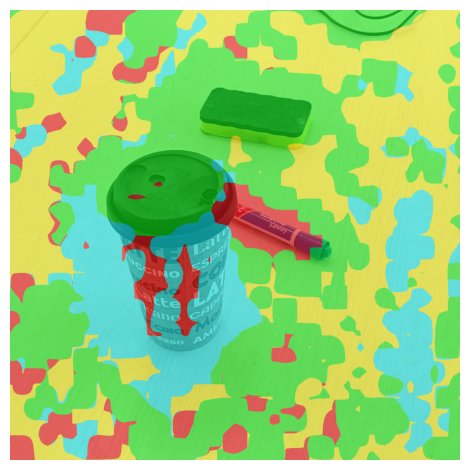

In [29]:


img = read_image('images/img6.jpg').to(device).float().unsqueeze(0)
plot_qualitative(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), output_file, palette)

In [47]:
img.shape

torch.Size([1, 3, 602, 1040])

In [13]:
mask

tensor([[[3, 2, 2,  ..., 2, 1, 1],
         [2, 2, 2,  ..., 2, 0, 0],
         [2, 2, 2,  ..., 2, 2, 0],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]], device='cuda:0')

In [35]:
img.shape

torch.Size([1, 3, 578, 578])

In [26]:
def plot_qualitative(image, sim, output_path, palette):
    qualitative_plot = np.zeros((sim.shape[0], sim.shape[1], 3)).astype(np.uint8)

    for j in list(np.unique(sim)):
        qualitative_plot[sim == j] = np.array(palette[j])
    plt.axis('off')
    print(image.shape, qualitative_plot.shape)
    plt.imshow(image)
    plt.imshow(qualitative_plot, alpha=0.5)
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [29]:
mask.shape

torch.Size([2, 37, 37])

In [5]:
model = build_model(cfg.model)
model.to(device).eval()

NameError: name 'build_model' is not defined

In [10]:
from src.model import ProjectionLayer, VisualProjectionLayer, CLIPLastLayer, DoubleMLP
from math import sqrt
import torch.nn.functional as F

def generate_masks(model, image, img_metas, text_emb, classnames, pca_model, text_is_token=False, apply_pamr=False, background_func="weighted_average_sigmoid", lambda_bg=0.2,
            # kp_w=0.3,
    ):
        """Generate masks for each text embeddings

        Args:
            image [B, 3, H, W]

        Returns:
            softmask [B, N, H, W]: softmasks for each text embeddings
        """

        H, W = image.shape[2:]  # original image shape

        # padded image size
        pH, pW = image.shape[2:]
        num_classes = text_emb.shape[0]
        batch_size = image.shape[0]

        image = image[:, [2, 1, 0], :, :]  # BGR to RGB
        ori_image = image.clone()
        
        img_preprocessed = model.image_transforms(image).to(device)
        if 'dinov2' in model.model_name:
            image_feat = model.model.forward_features(img_preprocessed)['x_norm_patchtokens']
        elif 'mae' in model.model_name or 'clip' in model.model_name or 'dino' in model.model_name:
            image_feat = model.model.forward_features(img_preprocessed)[:, 1:, :]
        elif 'sam' in model.model_name:
            model.model.forward_features(img_preprocessed)
            image_feat = feats['vit_out'].reshape(feats['vit_out'].shape[0], feats['vit_out'].shape[1]**2, feats['vit_out'].shape[-1]) # BS x N_PATCHES x EMBED_DIM
              
        batch_size, num_tokens, embed_dim = image_feat.shape

        print(image_feat.shape)
        
    
        if type(model.proj) == VisualProjectionLayer:
            image_feat = model.proj.project_dino(image_feat.float())
        if type(model.proj) == DoubleMLP:
            image_feat = model.proj.project_visual(image_feat.float())
        b, np, c = image_feat.shape
        np_h = np_w = int(sqrt(np))
        image_feat = image_feat.reshape(b, np_h, np_w, c).permute(0, 3, 1, 2)

        print(image_feat.shape, model.proj)

        image_proj = pca_model.transform(image_feat.reshpe(-1, embed_dim))
        image_proj = image_proj.reshape(batch_size, 37, 37, 3)
        
        
        self_attn, self_attn_maps = model.process_self_attention(model.feats['self_attn'], batch_size, num_tokens + model.num_global_tokens, model.num_attn_heads, embed_dim, model.scale, model.num_global_tokens, ret_self_attn_maps=True)
        mask, simmap = model.masker.forward_seg(image_feat, text_emb, hard=False)  # [B, N, H', W']
        
        if model.with_bg_clean:
            mask = model.similarity_assignment_weighted(mask, image_feat, self_attn_maps, text_emb, lambda_bg)

        # resize
        mask = F.interpolate(mask, (pH, pW), mode='bilinear', align_corners=True)  # [B, N, H, W]

        if apply_pamr:
            for c in range(0, mask.shape[1], 30):
                mask[:, c:c + 30] = model.apply_pamr(ori_image, mask[:, c:c + 30])

        assert mask.shape[2] == H and mask.shape[3] == W, f"shape mismatch: ({H}, {W}) / {mask.shape}"

        # return image_feat

        return mask, simmap

In [66]:
embeddings_tensor = generate_masks(model, img, img_metas=None, text_emb=text_emb, classnames=text, apply_pamr=True)

torch.Size([1, 1369, 768])
torch.Size([1, 768, 37, 37]) ProjectionLayer(
  (linear_layer): Linear(in_features=512, out_features=768, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=768, out_features=768, bias=True)
  )
  (act): Tanh()
)


NameError: name 'pca_model' is not defined

In [12]:
model.model_name

'dinov2_vitb14_reg'

In [16]:
from models.dinotext.pamr import PAMR

@torch.no_grad()
def generate_masks(
        model, image, img_metas, text_emb, classnames, pca_model=None, n_components=64,
        text_is_token=False, apply_pamr=False, background_func="weighted_average_sigmoid", lambda_bg=0.2,
):
    """Generate masks for each text embeddings with PCA dimensionality reduction

    Args:
        model: the model instance containing necessary components
        image [B, 3, H, W]: input image
        img_metas: image metadata
        text_emb [N, C]: text embeddings for classes
        classnames: list of class names
        pca_model: trained PCA model for dimensionality reduction
        n_components: number of components for PCA if model not provided
        text_is_token: whether text is provided as tokens
        apply_pamr: whether to apply PAMR refinement
        background_func: method for background handling
        lambda_bg: weight for background similarity

    Returns:
        softmask [B, N, H, W]: softmasks for each text embedding
        simmap: similarity map (optional)
    """
    # Original image dimensions
    H, W = image.shape[2:]
    batch_size = image.shape[0]
    num_classes = text_emb.shape[0]

    # Convert BGR to RGB
    image = image[:, [2, 1, 0], :, :]
    ori_image = image.clone()
    
    # Preprocess image and get features
    img_preprocessed = model.image_transforms(image).to(device)
    
    if 'dinov2' in model.model_name:
        image_feat = model.model.forward_features(img_preprocessed)['x_norm_patchtokens']
    elif 'mae' in model.model_name or 'clip' in model.model_name or 'dino' in model.model_name:
        image_feat = model.model.forward_features(img_preprocessed)[:, 1:, :]
    
    batch_size, num_tokens, embed_dim = image_feat.shape
    
    # Apply PCA to reduce dimensionality
    if pca_model is not None:
        # Flatten features and apply PCA
        image_feat_flat = image_feat.reshape(-1, embed_dim).cpu().numpy()
        text_emb_flat = text_emb.cpu().numpy()
        
        # Transform both image and text features
        image_feat_reduced = pca_model.transform(image_feat_flat)
        text_emb_reduced = pca_model.transform(text_emb_flat)
        
        # Convert back to tensors
        image_feat_reduced = torch.from_numpy(image_feat_reduced).to(device)
        text_emb_reduced = torch.from_numpy(text_emb_reduced).to(device)
        
        # Reshape back to original structure
        image_feat = image_feat_reduced.reshape(batch_size, num_tokens, -1)
        text_emb = text_emb_reduced.reshape(num_classes, -1)
    else:
        # If no PCA model provided, use original features
        pass

    # # Project features if needed
    # if type(model.proj) == VisualProjectionLayer:
    #     image_feat = model.proj.project_dino(image_feat.float())
    # elif type(model.proj) == DoubleMLP:
    #     image_feat = model.proj.project_visual(image_feat.float())

    # Reshape image features to spatial dimensions
    b, np, c = image_feat.shape
    np_h = np_w = int(sqrt(np))
    image_feat = image_feat.reshape(b, np_h, np_w, c).permute(0, 3, 1, 2)
    
    # # Process self-attention maps
    # self_attn, self_attn_maps = model.process_self_attention(
    #     model.feats['self_attn'], batch_size, num_tokens + model.num_global_tokens,
    #     model.num_attn_heads, embed_dim, model.scale, model.num_global_tokens, ret_self_attn_maps=True
    # )
    
    # Compute similarity and generate masks
    mask, simmap = model.masker.forward_seg(image_feat, text_emb, hard=False)
    print(mask)
    
    # # Apply background cleaning if needed
    # if model.with_bg_clean:
    #     mask = model.similarity_assignment_weighted(mask, image_feat, self_attn_maps, text_emb, lambda_bg)

    # Resize mask to original image dimensions
    mask = F.interpolate(mask, (H, W), mode='bilinear', align_corners=True)

    # Apply PAMR refinement if requested
    if apply_pamr:
        if model.pamr is None:
            pamr_iter = 10
            pamr_kernel = [1, 2, 4, 8, 12, 24]
            model.pamr = PAMR(pamr_iter, pamr_kernel)
            model.pamr.eval()
            model.pamr.to(next(model.parameters()).device)
            
        for c in range(0, mask.shape[1], 30):
            mask[:, c:c + 30] = model.apply_pamr(ori_image.float(), mask[:, c:c + 30].float())

    assert mask.shape[2] == H and mask.shape[3] == W, f"Shape mismatch: ({H}, {W}) / {mask.shape}"

    return mask, simmap

In [17]:
img = read_image('images/img6.jpg').to(device).float().unsqueeze(0)
# text = 'railway,train,background,grass'
text = 'cup,marker,table,sponge'
text = text.replace("_", " ").split(",")
palette = [
    [255, 0, 0],
    [255, 255, 0],
    [0, 255, 0],
    [0, 255, 255],
    [0, 0, 255],
    [128, 128, 128]
]
if len(text) > len(palette):
    for _ in range(len(text) - len(palette)):
        palette.append([np.random.randint(0, 255) for _ in range(3)])
        
if with_background:
    palette.insert(0, [0, 0, 0])
    model.with_bg_clean = True

with torch.no_grad():
    text_emb = model.build_dataset_class_tokens("sub_imagenet_template", text)
    text_emb = model.build_text_embedding(text_emb)

In [27]:
mask, simmap = generate_masks(model, img, pca_model=pca, img_metas=None, text_emb=text_emb, classnames=text, apply_pamr=True)

tensor([[[[8.7436e-01, 8.4136e-01, 2.8256e-01,  ..., 6.4650e-03,
           9.9533e-02, 3.9433e-01],
          [9.9088e-01, 3.0477e-01, 8.0852e-02,  ..., 3.8691e-03,
           1.2808e-02, 2.9899e-01],
          [2.2503e-01, 2.2632e-01, 1.9095e-02,  ..., 2.5819e-03,
           1.2328e-02, 4.7172e-02],
          ...,
          [3.3859e-03, 6.3588e-04, 1.6374e-02,  ..., 6.7183e-03,
           4.7714e-03, 2.1923e-02],
          [5.0708e-01, 1.3560e-01, 1.5641e-02,  ..., 2.9916e-03,
           1.3297e-02, 2.0499e-01],
          [3.1206e-01, 2.2625e-01, 1.3015e-03,  ..., 2.7985e-04,
           4.9856e-02, 3.2308e-01]],

         [[8.7238e-01, 8.4075e-01, 2.7892e-01,  ..., 6.8144e-03,
           1.0502e-01, 4.0756e-01],
          [9.9052e-01, 2.9933e-01, 7.9458e-02,  ..., 4.0470e-03,
           1.3645e-02, 3.1041e-01],
          [2.2034e-01, 2.2150e-01, 1.8797e-02,  ..., 2.6893e-03,
           1.3139e-02, 5.0068e-02],
          ...,
          [3.3288e-03, 6.3695e-04, 1.6065e-02,  ..., 6.8240

In [32]:
import torch
import gc

# Освобождение памяти
gc.collect()
torch.cuda.empty_cache()

In [24]:
mask.shape

torch.Size([1, 1280])

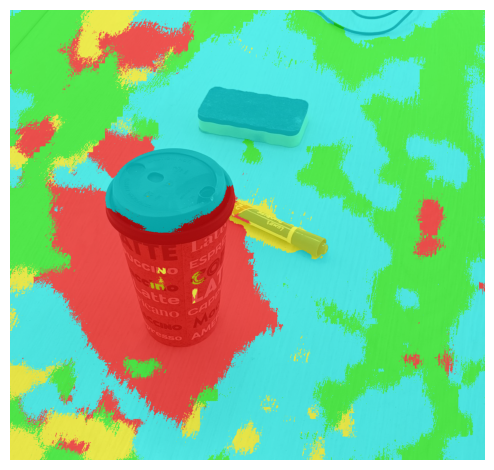

In [22]:
# if with_background:
#     background = torch.ones_like(mask[:, :1]) * 0.55
#     mask = torch.cat([background, mask], dim=1)

mask = mask.argmax(dim=1)
    
plot_qualitative(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), output_file, palette) # 10

In [11]:
embeddings_tensor = extract_image_embeddings("images/", model)

img6.jpg
torch.Size([3, 1215, 1280])
img5.jpg
torch.Size([3, 1254, 1280])
img4.jpg
torch.Size([3, 1280, 1243])


In [26]:
from sklearn.decomposition import PCA
# Преобразование в матрицу
X = embeddings_tensor.reshape(-1, 768).cpu()

# Применение PCA
pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)

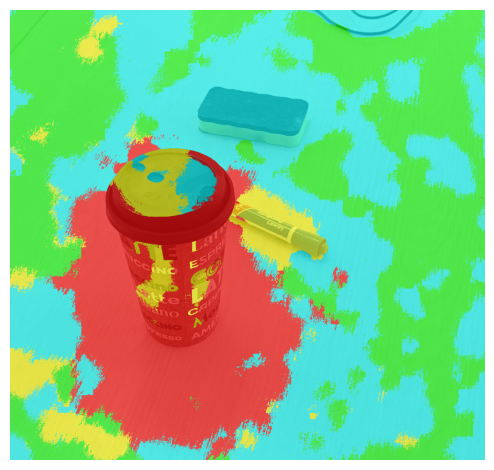

In [25]:
# if with_background:
#     background = torch.ones_like(mask[:, :1]) * 0.55
#     mask = torch.cat([background, mask], dim=1)

mask = mask.argmax(dim=1)
    
plot_qualitative(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), output_file, palette) # 700

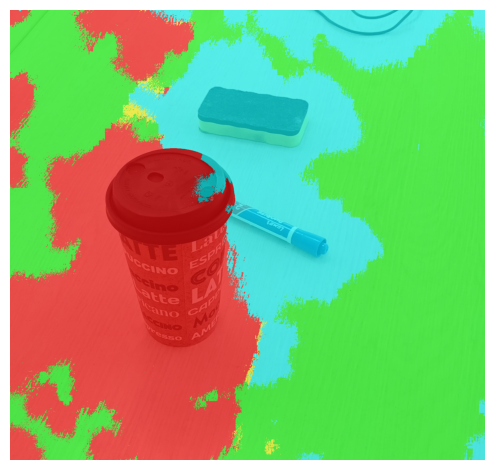

In [28]:
# if with_background:
#     background = torch.ones_like(mask[:, :1]) * 0.55
#     mask = torch.cat([background, mask], dim=1)

mask = mask.argmax(dim=1)
    
plot_qualitative(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), output_file, palette) # 3